In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
data=pd.read_csv(r"C:\Users\Deepu\Soft Computing Project\SD3\data.csv",sep='\t')
data.head()

,M1,M2,M3,M4,M5,M6,M7,M8,M9,N1,...,P2,P3,P4,P5,P6,P7,P8,P9,country,source
0,4,4,4,4,4,4,4,3,4,2,...,4,3,2,4,4,4,4,4,GB,1
1,2,1,5,2,2,1,2,2,3,1,...,1,1,5,4,1,5,3,2,US,1
2,3,3,3,5,1,1,5,5,3,2,...,5,3,1,3,1,2,3,1,US,1
3,5,5,4,5,5,5,5,5,5,5,...,1,5,2,5,5,5,1,5,GB,3
4,4,4,2,5,5,5,4,1,4,3,...,5,3,1,4,3,5,4,1,GB,3


In [5]:
question_cols = data.columns[:-2]
tech_cols = ['source', 'country']  # technical information
data[question_cols] = data[question_cols].apply(pd.to_numeric, errors='coerce')
X = data[question_cols].values

In [6]:
question_cols

Index(['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'N1', 'N2', 'N3',
       'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9'],
      dtype='object')

In [7]:
X

array([[4, 4, 4, ..., 4, 4, 4],
       [2, 1, 5, ..., 5, 3, 2],
       [3, 3, 3, ..., 2, 3, 1],
       ...,
       [4, 3, 3, ..., 2, 4, 1],
       [5, 4, 3, ..., 4, 1, 3],
       [4, 4, 4, ..., 3, 4, 4]], dtype=int64)

In [11]:
import joblib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# PCA & Pseudo‑labels
X_norm = (X - 1) / 4.0  
pca = PCA(n_components=15)
X_reduced = pca.fit_transform(X_norm)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
joblib.dump(pca, 'pca_transform.pkl')


['pca_transform.pkl']

Epoch 1/20 — Train Loss: 1.0485, Val Loss: 0.7453
Epoch 2/20 — Train Loss: 0.3776, Val Loss: 0.2661
Epoch 3/20 — Train Loss: 0.2321, Val Loss: 0.2137
Epoch 4/20 — Train Loss: 0.1910, Val Loss: 0.1716
Epoch 5/20 — Train Loss: 0.1639, Val Loss: 0.1575
Epoch 6/20 — Train Loss: 0.1585, Val Loss: 0.1492
Epoch 7/20 — Train Loss: 0.1456, Val Loss: 0.1430
Epoch 8/20 — Train Loss: 0.1388, Val Loss: 0.1333
Epoch 9/20 — Train Loss: 0.1324, Val Loss: 0.1327
Epoch 10/20 — Train Loss: 0.1277, Val Loss: 0.1239
Epoch 11/20 — Train Loss: 0.1257, Val Loss: 0.1164
Epoch 12/20 — Train Loss: 0.1215, Val Loss: 0.1103
Epoch 13/20 — Train Loss: 0.1164, Val Loss: 0.1136
Epoch 14/20 — Train Loss: 0.1138, Val Loss: 0.1106
Epoch 15/20 — Train Loss: 0.1102, Val Loss: 0.1047
Epoch 16/20 — Train Loss: 0.1076, Val Loss: 0.1062
Epoch 17/20 — Train Loss: 0.1045, Val Loss: 0.0998
Epoch 18/20 — Train Loss: 0.1016, Val Loss: 0.0986
Epoch 19/20 — Train Loss: 0.0996, Val Loss: 0.0981
Epoch 20/20 — Train Loss: 0.0969, Val Lo

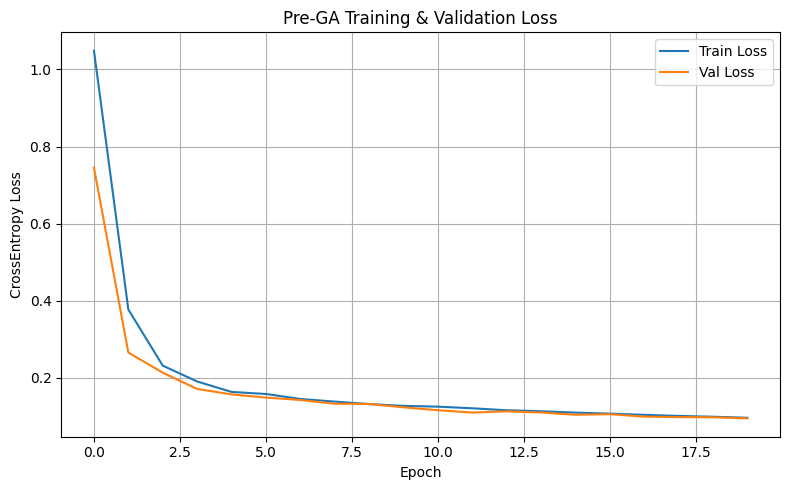

In [ ]:
import torch  # Pre-GA Training
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


X_norm = (X - 1) / 4.0  

# PCA & Pseudo‑labels
pca = PCA(n_components=15)
X_reduced = pca.fit_transform(X_norm)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
pseudo_labels = kmeans.fit_predict(X_reduced)  

X_t = torch.tensor(X_reduced, dtype=torch.float32)
y_t = torch.tensor(pseudo_labels, dtype=torch.long)  

# ANFIS Model Definition (output_dim=3)
class FuzzyLayer(nn.Module):
    def __init__(self, input_dim, num_mfs=2):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(input_dim, num_mfs))
        self.sigmas  = nn.Parameter(torch.rand(input_dim, num_mfs))

    def forward(self, x):
        x_exp = x.unsqueeze(2)                      
        return torch.exp(- (x_exp - self.centers)**2
                         / (2 * self.sigmas**2 + 1e-6))  # [B, F, M]

class RuleLayer(nn.Module):
    def forward(self, x):
        # flatten all fuzzy memberships into rule strengths
        return x.view(x.size(0), -1)  # [B, F*M]

class ConsequentLayer(nn.Module):
    def __init__(self, num_rules, output_dim=3):
        super().__init__()
        self.consequents = nn.Parameter(torch.rand(num_rules, output_dim))

    def forward(self, x):  # x : Batch_size,num_rules and output would be Batch_size,output_dim
        norm = x / (x.sum(1, keepdim=True) + 1e-6)  
        return norm @ self.consequents              

class ANFIS(nn.Module):
    def __init__(self, input_dim, num_mfs=2, output_dim=3):
        super().__init__()
        self.fuzzy  = FuzzyLayer(input_dim, num_mfs)
        self.rule   = RuleLayer()
        self.conseq = ConsequentLayer(input_dim * num_mfs, output_dim)

    def forward(self, x):
        return self.conseq(self.rule(self.fuzzy(x)))  

n = X_t.size(0)
perm = torch.randperm(n)
split = int(0.8 * n)
train_idx, val_idx = perm[:split], perm[split:]
X_train, y_train = X_t[train_idx], y_t[train_idx]
X_val,   y_val   = X_t[val_idx],   y_t[val_idx]


model = ANFIS(input_dim=15, num_mfs=2, output_dim=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


epochs = 20
batch_size = 16
train_losses, val_losses = [], []

for ep in range(epochs):
    model.train()
    epoch_loss = 0
    idxs = torch.randperm(X_train.size(0))
    for i in range(0, X_train.size(0), batch_size):
        batch = idxs[i:i+batch_size]
        xb, yb = X_train[batch], y_train[batch]
        optimizer.zero_grad()
        logits = model(xb)                   # [B,3]
        loss = criterion(logits, yb)         
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    train_losses.append(epoch_loss / len(train_idx))

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = criterion(val_logits, y_val).item()
        val_losses.append(val_loss)

    print(f"Epoch {ep+1}/{epochs} — Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}")

model.eval()
with torch.no_grad():
    train_logits = model(X_train)
    train_pred   = train_logits.argmax(dim=1)
    acc_train    = accuracy_score(y_train.numpy(), train_pred.numpy())
    val_pred     = model(X_val).argmax(dim=1)
    acc_val      = accuracy_score(y_val.numpy(), val_pred.numpy())

print("\nPre‑GA Metrics:")
print(f"  Train Acc: {acc_train*100:.2f}%")
print(f"  Val   Acc: {acc_val*100:.2f}%")

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Pre‑GA Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pre‑GA — Train Acc: 0.9656, Val Acc: 0.9635
Gen 1/60 — Best Val Acc: 0.9615
Gen 2/60 — Best Val Acc: 0.9615
Gen 3/60 — Best Val Acc: 0.9621
Gen 4/60 — Best Val Acc: 0.9621
Gen 5/60 — Best Val Acc: 0.9629
Gen 6/60 — Best Val Acc: 0.9629
Gen 7/60 — Best Val Acc: 0.9629
Gen 8/60 — Best Val Acc: 0.9629
Gen 9/60 — Best Val Acc: 0.9648
Gen 10/60 — Best Val Acc: 0.9648
Gen 11/60 — Best Val Acc: 0.9665
Gen 12/60 — Best Val Acc: 0.9665
Gen 13/60 — Best Val Acc: 0.9665
Gen 14/60 — Best Val Acc: 0.9673
Gen 15/60 — Best Val Acc: 0.9698
Gen 16/60 — Best Val Acc: 0.9698
Gen 17/60 — Best Val Acc: 0.9706
Gen 18/60 — Best Val Acc: 0.9706
Gen 19/60 — Best Val Acc: 0.9733
Gen 20/60 — Best Val Acc: 0.9764
Gen 21/60 — Best Val Acc: 0.9764
Gen 22/60 — Best Val Acc: 0.9764
Gen 23/60 — Best Val Acc: 0.9764
Gen 24/60 — Best Val Acc: 0.9772
Gen 25/60 — Best Val Acc: 0.9772
Gen 26/60 — Best Val Acc: 0.9772
Gen 27/60 — Best Val Acc: 0.9775
Gen 28/60 — Best Val Acc: 0.9775
Gen 29/60 — Best Val Acc: 0.9775
Gen 30/6

,Metric,Pre‑GA,Post‑GA
0,Train Acc,0.965643,0.976156
1,Val Acc,0.963451,0.981588


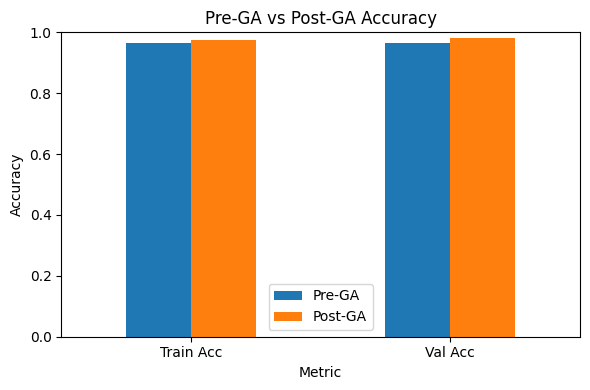

In [9]:
import numpy as np  # GA & Post GA Analysis
import torch
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt


def get_flat(model):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model.parameters()])

def set_flat(model, arr):
    ptr = 0
    for p in model.parameters():
        num = p.numel()
        vals = arr[ptr:ptr+num].reshape(p.shape)
        p.data = torch.tensor(vals, dtype=p.data.dtype)
        ptr += num

model.eval()
with torch.no_grad():
    train_logits = model(X_train)
    train_pred   = train_logits.argmax(dim=1)
    acc_train_pre = accuracy_score(y_train.numpy(), train_pred.numpy())
    val_logits   = model(X_val)
    val_pred     = val_logits.argmax(dim=1)
    acc_val_pre   = accuracy_score(y_val.numpy(),   val_pred.numpy())

print(f"Pre‑GA — Train Acc: {acc_train_pre:.4f}, Val Acc: {acc_val_pre:.4f}")

# GA Hyperparameters
pop_size, gens = 100, 60
mut_rate, cross_rate = 0.2, 0.7

base = get_flat(model)
dim  = base.shape[0]
pop  = np.array([base + np.random.randn(dim)*0.05 for _ in range(pop_size)])

# Fitness Function is defined as accuracy on validation set
def fitness(sol):
    set_flat(model, sol)
    model.eval()
    with torch.no_grad():
        logits = model(X_val)
        pred   = logits.argmax(dim=1).cpu().numpy()
    return accuracy_score(y_val.numpy(), pred)

# Evolution Loop
best_fit, best_sol = -1.0, None

for g in range(1, gens+1):
    fits = np.array([fitness(ind) for ind in pop])
    idx  = fits.argmax()
    if fits[idx] > best_fit:
        best_fit, best_sol = fits[idx], pop[idx].copy()

    # Tournament selection (size=3)
    selected = []
    for _ in range(pop_size):
        tour = np.random.choice(pop_size, 3, replace=False)
        winner = tour[fits[tour].argmax()]
        selected.append(pop[winner])
    sel = np.array(selected)

    
    new_pop = []
    for i in range(0, pop_size, 2):
        p1, p2 = sel[i], sel[(i+1) % pop_size]
        if np.random.rand() < cross_rate:  # crossover used is single-point crossover
            pt = np.random.randint(1, dim)
            c1 = np.concatenate([p1[:pt], p2[pt:]])
            c2 = np.concatenate([p2[:pt], p1[pt:]])
        else:
            c1, c2 = p1.copy(), p2.copy()
        for c in (c1, c2):
            mask = np.random.rand(dim) < mut_rate
            c[mask] += np.random.randn(mask.sum()) * 0.1
        new_pop += [c1, c2]

    pop = np.array(new_pop[:pop_size])
    print(f"Gen {g}/{gens} — Best Val Acc: {best_fit:.4f}")

set_flat(model, best_sol)
model.eval()
with torch.no_grad():
    logits_tr = model(X_train)
    pred_tr   = logits_tr.argmax(dim=1)
    acc_train_post = accuracy_score(y_train.numpy(), pred_tr.numpy())
    logits_val = model(X_val)
    pred_val   = logits_val.argmax(dim=1)
    acc_val_post   = accuracy_score(y_val.numpy(),   pred_val.numpy())

print(f"\nPost‑GA — Train Acc: {acc_train_post:.4f}, Val Acc: {acc_val_post:.4f}")

comparison = pd.DataFrame({
    'Metric':   ['Train Acc', 'Val Acc'],
    'Pre‑GA':   [acc_train_pre,   acc_val_pre],
    'Post‑GA':  [acc_train_post,  acc_val_post]
})
print("\nPre vs Post GA Comparison:")
display(comparison)
torch.save(model.state_dict(), 'final_model_weights.pth')
# Plot Comparison
comparison.set_index('Metric')[['Pre‑GA','Post‑GA']].plot.bar(
    figsize=(6,4), rot=0
)
plt.title("Pre‑GA vs Post‑GA Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.tight_layout()
plt.show()


In [ ]:
from graphviz import Digraph

def visualize_anfis_architecture(input_dim, num_mfs, output_dim):
    dot = Digraph(format='png')
    dot.attr(rankdir='LR', size='10')

    # Input layer
    dot.node('Input', f'Input\n({input_dim})')

    # Fuzzy Layer
    for i in range(input_dim):
        for j in range(num_mfs):
            dot.node(f'μ_{i}_{j}', f'μ_{i}_{j}\n(Gaussian MF)', shape='ellipse')
            dot.edge('Input', f'μ_{i}_{j}')

    # Rule Layer
    dot.node('RuleLayer', 'Rule Layer\n(Combine MFs)', shape='box')
    for i in range(input_dim):
        for j in range(num_mfs):
            dot.edge(f'μ_{i}_{j}', 'RuleLayer')

    # Consequent Layer
    dot.node('ConsequentLayer', f'Consequent Layer\n({input_dim*num_mfs} rules)', shape='box')
    dot.edge('RuleLayer', 'ConsequentLayer')

    # Output Layer
    dot.node('Output', f'Output\n({output_dim})', shape='doublecircle')
    dot.edge('ConsequentLayer', 'Output')

    dot.render('anfis_block_diagram', view=True)

visualize_anfis_architecture(input_dim=9, num_mfs=2, output_dim=3)
